In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
 
import sklearn.preprocessing as skp
 
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout, Activation , Concatenate, Input , BatchNormalization
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Model,Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
 
import matplotlib.pyplot as plt
from glob import glob
 
 
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Preprocessing Descriptive Data


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Proj2_data/data2/desc.csv')
df.head()

,image_id,street,city,n_city,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


In [4]:
df.info()
df.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15474 entries, 0 to 15473
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   image_id  15474 non-null  int64  
 1   street    15474 non-null  object 
 2   city      15474 non-null  object 
 3   n_city    15474 non-null  int64  
 4   bed       15474 non-null  int64  
 5   bath      15474 non-null  float64
 6   sqft      15474 non-null  int64  
 7   price     15474 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 967.2+ KB


,count,mean,std,min,25%,50%,75%,max
image_id,15474.0,7736.500000,4467.103368,0.0,3868.25,7736.5,11604.75,15473.0
n_city,15474.0,216.597518,112.372985,0.0,119.00,222.5,315.00,414.0
bed,15474.0,3.506398,1.034838,1.0,3.00,3.0,4.00,12.0
bath,15474.0,2.453251,0.958742,0.0,2.00,2.1,3.00,36.0
sqft,15474.0,2173.913209,1025.339617,280.0,1426.00,1951.0,2737.75,17667.0
price,15474.0,703120.937508,376976.154421,195000.0,445000.00,639000.0,834975.00,2000000.0


In [5]:
df.isnull().sum()

image_id    0
street      0
city        0
n_city      0
bed         0
bath        0
sqft        0
price       0
dtype: int64

No need to retrieve null values.

In [6]:
df.columns

Index(['image_id', 'street', 'city', 'n_city', 'bed', 'bath', 'sqft', 'price'], dtype='object')

To see which parameters are more correlated with each other, we draw a pairplot.

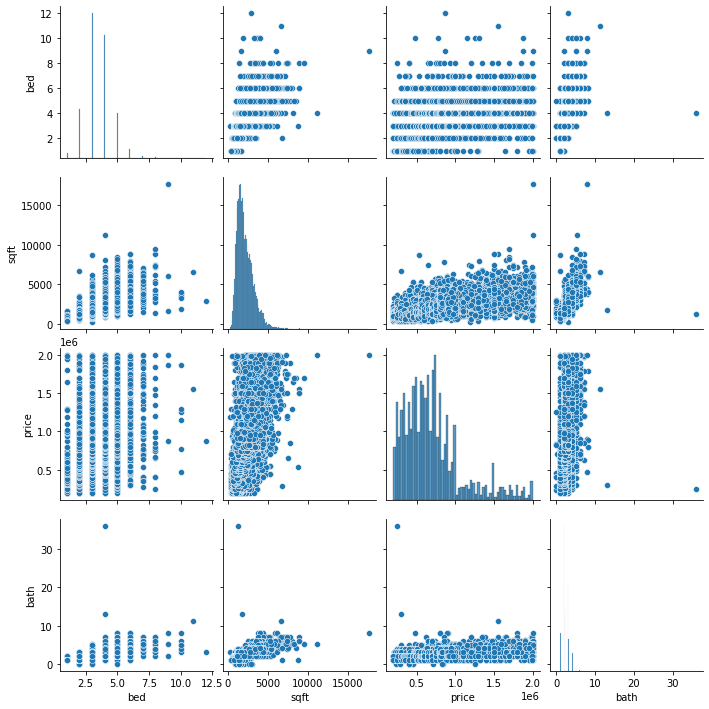

In [7]:
sns.pairplot(data = df[['bed','sqft','price','bath' ]])
plt.show()

In [8]:
print(len(np.unique(df['street'])))
print(len(np.unique(df['city'])))

12401
415


In [9]:
print(df.shape)

(15474, 8)


In [10]:
 len(np.unique(df['city'][10]))

1

In [11]:
f = True
for c in df['city']:
  if ', CA' not in c:
    f = f & False
if f == True:
  df['city'] = df['city'].apply(lambda c :  c[ : -4] )


In [12]:
 df['street'].head(10)

0    1317 Van Buren Avenue
1           124 C Street W
2          2304 Clark Road
3       755 Brawley Avenue
4    2207 R Carrillo Court
5       755 Brawley Avenue
6      1100 CAMILIA Street
7      803 Chaparral Court
8      803 Chaparral Court
9          2306 Lark Court
Name: street, dtype: object

In [13]:
for s in df['street']:
  if 'Dixie Street' in s:
    print(s)
for s in df['street']:
  if 'Lakeview Drive' in s:
    print(s)

2822 Dixie Street
2822 Dixie Street
7108 Lakeview Drive
6788 Lakeview Drive
39900 Lakeview Drive
18195 Lakeview Drive
40218 Lakeview Drive
40218 Lakeview Drive


So there is different numbers with same street.
First let's split numbers and street names and store them in two different columns and check out whether there is any correlation between street numbers and prices.

In [14]:
import re

In [15]:
numbers=[]
street_name=[]

splitted =  [ re.split('^(\d+)',s) for s in df['street']]
for st in range(len(splitted)):
  if len(splitted[st]) >1:
    numbers.append(int(splitted[st][1]))
    street_name.append(splitted[st][2])
  else:
    numbers.append(None)
    street_name.append('')

# splitted
numbers = pd.to_numeric(numbers)


df['number'] = numbers.astype('float32')
street_names=street_name



In [16]:
len(np.unique(street_names))

10467

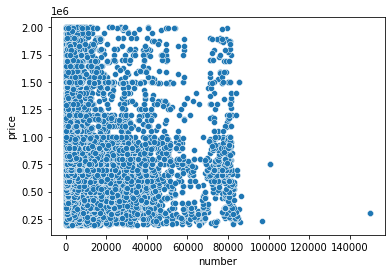

In [17]:
sns.scatterplot( x = df['number'] , y = df['price'] )
plt.show()

Because there is so many different cities and street names and dimension of data frame would be so large, we don't consider them for now.
But adding numbers column to the dataframe add only one column so we can consider that. 

Also there can be a correlation due to the plot.

There might be a pattern. We will see this later in MLP models.

Bathrooms:

In [18]:
import math

In [19]:
f = True
cnt = 0
master_bath = np.zeros(15474)
nonMaster_bath = np.zeros(15474)  
for b in df['bath']:
   separated_num = math.modf(b)
   master_bath[cnt] = separated_num[1]
   nonMaster_bath[cnt] = round(separated_num[0], 1)
   cnt+=1

In [20]:
master_bath

array([2., 2., 1., ..., 2., 2., 2.])

In [21]:
nonMaster_bath.max(), nonMaster_bath.min()

(0.4, 0.0)

In [22]:
df['master_bath'] = master_bath
df['nonMaster_bath'] = nonMaster_bath

In [25]:
df[['master_bath', 'nonMaster_bath']].head(5)

,master_bath,nonMaster_bath
0,2.0,0.0
1,2.0,0.0
2,1.0,0.0
3,1.0,0.0
4,3.0,0.0


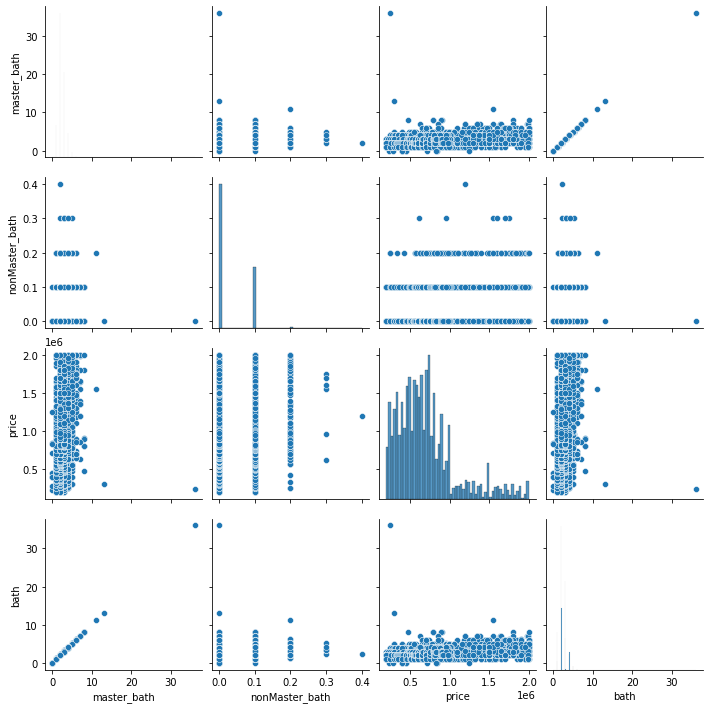

In [26]:
sns.pairplot(data = df[['master_bath', 'nonMaster_bath','price','bath' ]])
plt.show()

It might help so we will see this then.

###Standardize the data

In [27]:
SAMPLE_SIZE = 3000
SAMPLE_TRAIN = int(0.75 * SAMPLE_SIZE)
SAMPLE_TEST = int(0.25 * SAMPLE_SIZE)

In [28]:
import random
learn_random = random.sample(range(12379), SAMPLE_SIZE)

In [29]:
X = df.drop(labels=['price','city','street','image_id', 'bath','number'], axis=1).iloc[learn_random]
y = df['price'].iloc[learn_random]

In [30]:
#To see if number column and separating bathrooms will help.
X_with_numbers = df.drop(labels=['price','city','street','image_id', 'bath'], axis=1).iloc[learn_random]
X_with_def_bath = df.drop(labels=['price','city','street','image_id', 'master_bath', 'nonMaster_bath'], axis=1).iloc[learn_random]

In [31]:
for c in X.columns:
  m = max(X[c])
  X[c] = (X[c] - min(X[c])) / m

MAX_PRICE = max(y) 
MIN_PRICE = min(y)
y = y.astype('float32') / MAX_PRICE

In [32]:
for c in X_with_numbers.columns:
  m = max(X_with_numbers[c])
  X_with_numbers[c] = (X_with_numbers[c] - min(X_with_numbers[c])) / m

for c in X_with_def_bath.columns:
  m = max(X_with_def_bath[c])
  X_with_def_bath[c] = (X_with_def_bath[c] - min(X_with_def_bath[c])) / m

In [33]:
X.iloc[0]

n_city            0.219807
bed               0.300000
sqft              0.040754
master_bath       0.250000
nonMaster_bath    0.000000
Name: 1783, dtype: float64

They're in range.

In [34]:
X= np.array(X).astype('float32')
y= np.array(y).astype('float32').reshape(-1,1)

In [35]:
X1 = np.array(X_with_numbers).astype('float32')
X2 = np.array(X_with_def_bath).astype('float32') 

In [36]:
X_train= X[0:SAMPLE_TRAIN]
X_test = X[SAMPLE_TRAIN +1:]

y_train = y[0:SAMPLE_TRAIN]
y_test = y[SAMPLE_TRAIN+1:]

In [37]:
X1_train= X[0:SAMPLE_TRAIN]
X2_train= X[0:SAMPLE_TRAIN]

X1_test = X[SAMPLE_TRAIN +1:]
X2_test = X[SAMPLE_TRAIN +1:]


In [38]:
y_train.shape

(2250, 1)

In [39]:
X_train.shape

(2250, 5)

In [40]:
y_train[1]

array([0.1895], dtype=float32)

In [41]:
y_test.shape

(749, 1)

In [42]:
X_test.shape

(749, 5)

# Preprocessing Image Data 

In [ ]:
#!unzip '/gdrive/My Drive/Proj2_data/data2/pics.zip' -d '/gdrive/My Drive/Proj2_data/data2'

In [43]:
import PIL.Image

In [44]:
import pathlib
data_dir = '/content/drive/MyDrive/Colab Notebooks/dataimg2-2/pics'
data_dir = pathlib.Path(data_dir)

In [46]:
import random

images_path_ran = [ str(data_dir)+'/' + str(i) + '.jpg' for i in learn_random ]
print(images_path_ran[0])

/content/drive/MyDrive/Colab Notebooks/dataimg2-2/pics/1783.jpg


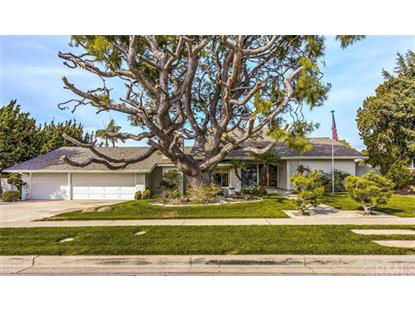

In [53]:
PIL.Image.open(images_path_ran[22])

Codes for models with size 128*128 are commented due to taking a lot of time.

In [54]:
import cv2


# X_images_128 = np.zeros((SAMPLE_SIZE, 128, 128, 3), dtype="uint32")
X_images_64 = np.zeros((SAMPLE_SIZE, 64, 64, 3), dtype="uint32")

i = 0
for filename in images_path_ran:

      img = cv2.imread(str(filename))

      if img is not None:

          # img_128 = cv2.resize(img, (128, 128))
          img_64 = cv2.resize(img , (64,64))

          # X_images_128[i] = img_128
          X_images_64[i] = img_64

          i+=1

In [55]:
X_images_64.shape

(3000, 64, 64, 3)

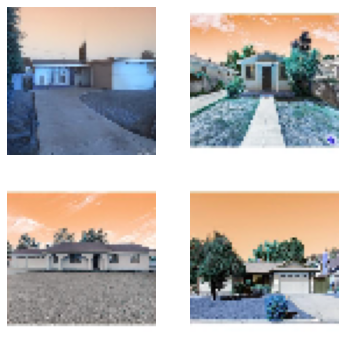

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))

for i in range(4):
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(X_images_64[i])
  plt.axis("off")

________________________________________________________

In [59]:
#Split Color Set
# X_train_color_128 =X_images_128[:SAMPLE_TRAIN]
X_train_color_64 = X_images_64[:SAMPLE_TRAIN]

# X_test_color_128 = X_images_128[SAMPLE_TRAIN+1:]
X_test_color_64 = X_images_64[SAMPLE_TRAIN+1:]

In [60]:
# To gray
# gray_img_128 = np.array([ cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in X_images_128.astype('float32')]).reshape(-1,128,128,1)
gray_img_64 = np.array([ cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in X_images_64.astype('float32')]).reshape(-1,64,64,1)


# Equalize
# equ_img_128 = np.array([ cv2.equalizeHist(img.astype(np.uint8)) for img in gray_img_128] ).reshape(-1,128,128,1)
equ_img_64 = np.array([ cv2.equalizeHist(img.astype(np.uint8)) for img in gray_img_64] ).reshape(-1,64,64,1)


Normalize:

In [61]:
#Split Gray Set
# X_train_gray_128 =equ_img_128 [:SAMPLE_TRAIN]/255.0
X_train_gray_64 =equ_img_64 [:SAMPLE_TRAIN]/255.0

# X_test_gray_128 = equ_img_128[SAMPLE_TRAIN+1:]/255.0
X_test_gray_64 = equ_img_64[SAMPLE_TRAIN+1:]/255.0

In [62]:
X_train_color_64 = X_train_color_64/255.0
X_test_color_64 = X_test_color_64/255.0

In [63]:
#Split Targets
y_trainImages = y_train
y_testImages = y_test

###Create Models

Create a class to organize creating and storing defferent models.

In [64]:
class Network:
  def __init__(self, kind , name , dim_desc = 0, dim_img = 0):

    self.name = name

    self.dim_desc = dim_desc
    self.dim_img = dim_img

    self.fitted_model = None

    if kind == 'mlp':

      self.model = self.create_mlp()
  
    elif kind == 'cnn':
      
      self.model = self.create_cnn()

    elif kind == 'fusion':

      model_mlp = self.create_mlp()
      model_cnn = self.create_cnn()

      model_concat = Concatenate(axis = 1)([model_mlp.output , model_cnn.output])

      model_concat = Dense(32, activation="relu")(model_concat)
      model_concat = Dropout(0.2)(model_concat)
      model_concat = Dense(16, activation="relu")(model_concat)
      model_concat = Dense(8, activation="relu")(model_concat)
      model_concat = Dense(1, activation="sigmoid")(model_concat)

      model_concat = Model(inputs=[model_mlp.input, model_cnn.input], outputs=model_concat)

      self.model = model_concat
      
    else:
      self.model = None
    
  def  create_mlp(self):

    mlp = Sequential()
    mlp.add(Dense(8 , input_dim = self.dim_desc[0], activation = 'relu'))
    mlp.add(Dense(4, activation="relu"))
    mlp.add(Dense(1, activation="linear"))
    return mlp

  def  create_cnn(self):

    cnn = Sequential()
    cnn.add(Conv2D(self.dim_img[0],input_shape=self.dim_img, kernel_size=(18, 18), activation='relu' ))
    cnn.add(BatchNormalization())
    cnn.add(Dropout(0.1))
    cnn.add(Conv2D(self.dim_img[0]*2,(15,15), activation='relu',name = 'Conv1_5'))
    cnn.add(BatchNormalization(name = 'Bnorm1'))
    cnn.add(Dropout(0.1))
    cnn.add(Conv2D(self.dim_img[0],(9,9), activation='relu', padding='same',name= 'Conv2_5'))
    cnn.add(BatchNormalization(name = 'Bnorm2'))
    cnn.add(MaxPooling2D((2, 2),name = 'MaxPool1'))
    cnn.add(Dropout(0.1))
    cnn.add(Conv2D(self.dim_img[0]/4,(7,7), activation='relu' ,padding='same',name = 'Conv3_3'))
    cnn.add(BatchNormalization(name = 'Bnorm3'))
    cnn.add(Conv2D(self.dim_img[0]/2,(6,6), activation='relu' ,padding='same',name = 'Conv4_3'))
    cnn.add(BatchNormalization(name = 'Bnorm4'))
    cnn.add(Dropout(0.1))
    cnn.add(AveragePooling2D((2, 2),name = 'AvgPool1'))
    cnn.add(Conv2D(128,(3,3), activation='relu' ,padding='valid',name = 'Conv5_1'))
    cnn.add(BatchNormalization(name = 'Bnorm5'))

    #Flatten
    cnn.add(Flatten(name = 'Flatten'))
    cnn.add(Dense(units = 64, activation = 'relu'))
    cnn.add(Dropout(rate = 0.2))
    cnn.add(BatchNormalization())
    cnn.add(Dense(units = 32, activation = 'relu'))
    cnn.add(Dropout(rate = 0.1))
    cnn.add(BatchNormalization())
    cnn.add(Dense(units = 15, activation = 'relu'))
    cnn.add(Dropout(rate = 0.2))
    cnn.add(BatchNormalization())
    cnn.add(Dense(units = 6, activation = 'relu'))
    cnn.add(BatchNormalization())
    cnn.add(Dense(units = 1, activation = 'sigmoid' , name='preds'))

    return cnn

  def plot(self):
    plt.plot(self.fitted_model.history['loss'])
    plt.plot(self.fitted_model.history['val_loss'])
    plt.title(f'Model Loss for {self.name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Validation_loss'], loc='upper right')
    plt.show()

  def compile_model(self,optimizer) :

        self.model.compile(optimizer = optimizer, loss='mse')
        return self.model

  def fit_model(self,x_train , y_train,x_test , y_test , epochs, batch_size):

    es = EarlyStopping(monitor='val_loss', verbose=1, patience=7,mode = 'min' ) #when validation loss starts to increase means we start overfitting so it stops after 5 epochseses = [es]
    fitted_model = self.model.fit(x=x_train,
                                                y=y_train, 
                                                validation_data=(x_test, y_test),
                                                epochs=epochs, batch_size=batch_size ,callbacks=[es],verbose = 2)
    self.fitted_model = fitted_model

    return fitted_model

  def predict(self,test,target):
    preds = self.model.predict(test , target)
    return preds




<h2>Trynig Only MLP for Descriptive Data<h2>



In [49]:
train = [X_train, X1_train,X2_train]
test = [X_test, X1_test,X2_test]


Epoch 1/30
225/225 - 0s - loss: 0.0273 - val_loss: 0.0245
Epoch 2/30
225/225 - 0s - loss: 0.0235 - val_loss: 0.0246
Epoch 3/30
225/225 - 0s - loss: 0.0232 - val_loss: 0.0241
Epoch 4/30
225/225 - 0s - loss: 0.0230 - val_loss: 0.0240
Epoch 5/30
225/225 - 0s - loss: 0.0229 - val_loss: 0.0248
Epoch 6/30
225/225 - 0s - loss: 0.0228 - val_loss: 0.0239
Epoch 7/30
225/225 - 0s - loss: 0.0228 - val_loss: 0.0240
Epoch 8/30
225/225 - 0s - loss: 0.0227 - val_loss: 0.0244
Epoch 9/30
225/225 - 0s - loss: 0.0226 - val_loss: 0.0241
Epoch 10/30
225/225 - 0s - loss: 0.0226 - val_loss: 0.0238
Epoch 11/30
225/225 - 0s - loss: 0.0224 - val_loss: 0.0239
Epoch 12/30
225/225 - 0s - loss: 0.0224 - val_loss: 0.0239
Epoch 13/30
225/225 - 0s - loss: 0.0224 - val_loss: 0.0238
Epoch 14/30
225/225 - 0s - loss: 0.0225 - val_loss: 0.0238
Epoch 15/30
225/225 - 0s - loss: 0.0224 - val_loss: 0.0239
Epoch 16/30
225/225 - 0s - loss: 0.0224 - val_loss: 0.0238
Epoch 17/30
225/225 - 0s - loss: 0.0224 - val_loss: 0.0239
Epoch 

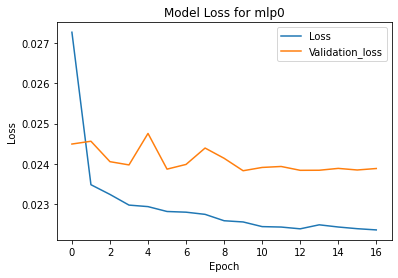

Epoch 1/30
225/225 - 0s - loss: 0.0850 - val_loss: 0.0411
Epoch 2/30
225/225 - 0s - loss: 0.0342 - val_loss: 0.0336
Epoch 3/30
225/225 - 0s - loss: 0.0300 - val_loss: 0.0311
Epoch 4/30
225/225 - 0s - loss: 0.0281 - val_loss: 0.0282
Epoch 5/30
225/225 - 0s - loss: 0.0268 - val_loss: 0.0272
Epoch 6/30
225/225 - 0s - loss: 0.0259 - val_loss: 0.0264
Epoch 7/30
225/225 - 0s - loss: 0.0250 - val_loss: 0.0257
Epoch 8/30
225/225 - 0s - loss: 0.0243 - val_loss: 0.0252
Epoch 9/30
225/225 - 0s - loss: 0.0239 - val_loss: 0.0250
Epoch 10/30
225/225 - 0s - loss: 0.0236 - val_loss: 0.0252
Epoch 11/30
225/225 - 0s - loss: 0.0234 - val_loss: 0.0245
Epoch 12/30
225/225 - 0s - loss: 0.0230 - val_loss: 0.0241
Epoch 13/30
225/225 - 0s - loss: 0.0230 - val_loss: 0.0241
Epoch 14/30
225/225 - 0s - loss: 0.0230 - val_loss: 0.0240
Epoch 15/30
225/225 - 0s - loss: 0.0227 - val_loss: 0.0240
Epoch 16/30
225/225 - 0s - loss: 0.0227 - val_loss: 0.0237
Epoch 17/30
225/225 - 0s - loss: 0.0226 - val_loss: 0.0241
Epoch 

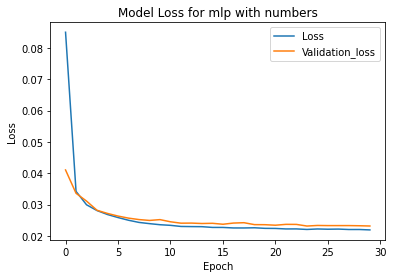

Epoch 1/30
225/225 - 0s - loss: 0.0656 - val_loss: 0.0297
Epoch 2/30
225/225 - 0s - loss: 0.0276 - val_loss: 0.0268
Epoch 3/30
225/225 - 0s - loss: 0.0249 - val_loss: 0.0246
Epoch 4/30
225/225 - 0s - loss: 0.0236 - val_loss: 0.0239
Epoch 5/30
225/225 - 0s - loss: 0.0229 - val_loss: 0.0241
Epoch 6/30
225/225 - 0s - loss: 0.0226 - val_loss: 0.0240
Epoch 7/30
225/225 - 0s - loss: 0.0225 - val_loss: 0.0239
Epoch 8/30
225/225 - 0s - loss: 0.0224 - val_loss: 0.0239
Epoch 9/30
225/225 - 0s - loss: 0.0223 - val_loss: 0.0242
Epoch 10/30
225/225 - 0s - loss: 0.0223 - val_loss: 0.0244
Epoch 11/30
225/225 - 0s - loss: 0.0224 - val_loss: 0.0249
Epoch 00011: early stopping


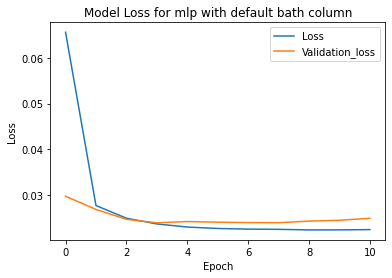

In [52]:
model_mlp = [Network('mlp' , 'mlp0' , dim_desc = X_train.shape[1:]),
                        Network('mlp' , 'mlp with numbers' , dim_desc = X1_train.shape[1:])  ,
                        Network('mlp' , 'mlp with default bath column' , dim_desc = X_train.shape[1:])]

for i in range(len(models_mlp)):
  model_mlp[i].compile_model(optimizer = 'adam')
  model_mlp[i].fit_model(x_train = train[i] , y_train = y_train, x_test = test[i], y_test = y_test ,epochs = 30,batch_size = 10)
  model_mlp[i].plot()

Model with numbers have the least loss and validation loss.

In [ ]:
#Set df with numbers as train set for all.
X_train = X1_train
X_test  = X2_test

<h2>Trynig Only CNN for Image Data <h2>

In [65]:
model_cnn = Network(kind = 'cnn' ,name = 'cnn1' , dim_img = X_train_color_64.shape[1:])
model_cnn.compile_model(optimizer='adam')
model_cnn.fit_model(x_train = X_train_color_64 , y_train = y_train, x_test = X_test_color_64, y_test = y_test ,epochs = 50,batch_size = 64)

Epoch 1/50
36/36 - 3s - loss: 0.1030 - val_loss: 0.1488
Epoch 2/50
36/36 - 2s - loss: 0.0751 - val_loss: 0.0861
Epoch 3/50
36/36 - 3s - loss: 0.0617 - val_loss: 0.0838
Epoch 4/50
36/36 - 3s - loss: 0.0502 - val_loss: 0.0464
Epoch 5/50
36/36 - 3s - loss: 0.0464 - val_loss: 0.0427
Epoch 6/50
36/36 - 3s - loss: 0.0426 - val_loss: 0.0455
Epoch 7/50
36/36 - 3s - loss: 0.0400 - val_loss: 0.0386
Epoch 8/50
36/36 - 2s - loss: 0.0368 - val_loss: 0.0383
Epoch 9/50
36/36 - 2s - loss: 0.0376 - val_loss: 0.0378
Epoch 10/50
36/36 - 2s - loss: 0.0372 - val_loss: 0.0381
Epoch 11/50
36/36 - 2s - loss: 0.0364 - val_loss: 0.0374
Epoch 12/50
36/36 - 2s - loss: 0.0360 - val_loss: 0.0373
Epoch 13/50
36/36 - 2s - loss: 0.0357 - val_loss: 0.0371
Epoch 14/50
36/36 - 2s - loss: 0.0360 - val_loss: 0.0372
Epoch 15/50
36/36 - 2s - loss: 0.0354 - val_loss: 0.0369
Epoch 16/50
36/36 - 2s - loss: 0.0357 - val_loss: 0.0376
Epoch 17/50
36/36 - 2s - loss: 0.0352 - val_loss: 0.0378
Epoch 18/50
36/36 - 2s - loss: 0.0350 - 

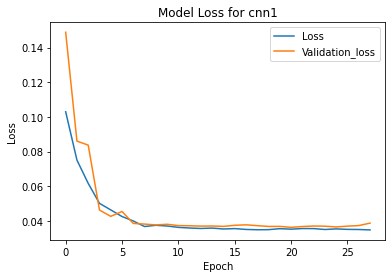

In [66]:
model_cnn.plot()

The result is only 0.01 better than mlp models.

<h1>Use Intput Fusion Method <h1>

In [69]:
fusion_models = [Network('fusion','Grayscale 64', dim_img = X_train_gray_64.shape[1:],dim_desc=X_train.shape[1:]),
                            Network('fusion','Color 64', dim_img = X_train_color_64.shape[1:],dim_desc=X_train.shape[1:]),
                            # Network('fusion','Grayscale 128', dim_img = X_train_gray_128.shape[1:],dim_desc=X_train.shape[1:]),
                            # Network('fusion','Color 128', dim_img = X_train_color_128.shape[1:],dim_desc=X_train.shape[1:])
                            ]

In [70]:
valid = [([X_test, X_test_gray_64], y_test),
            ([X_test, X_test_color_64], y_test),

            # ([X_test, X_test_gray_128], y_test),
            # ([X_test, X_test_color_128], y_test)
            ]
      
x = [[X_train, X_train_gray_64],
      [X_train, X_train_color_64], 

      # [X_train, X_train_gray_128],
      # [X_train, X_train_color_128]
     ]
                

Epoch 1/100
36/36 - 3s - loss: 0.0461 - val_loss: 0.0392
Epoch 2/100
36/36 - 2s - loss: 0.0365 - val_loss: 0.0381
Epoch 3/100
36/36 - 2s - loss: 0.0361 - val_loss: 0.0372
Epoch 4/100
36/36 - 2s - loss: 0.0354 - val_loss: 0.0365
Epoch 5/100
36/36 - 3s - loss: 0.0348 - val_loss: 0.0353
Epoch 6/100
36/36 - 3s - loss: 0.0339 - val_loss: 0.0343
Epoch 7/100
36/36 - 3s - loss: 0.0329 - val_loss: 0.0331
Epoch 8/100
36/36 - 2s - loss: 0.0320 - val_loss: 0.0321
Epoch 9/100
36/36 - 2s - loss: 0.0306 - val_loss: 0.0301
Epoch 10/100
36/36 - 2s - loss: 0.0291 - val_loss: 0.0283
Epoch 11/100
36/36 - 2s - loss: 0.0271 - val_loss: 0.0270
Epoch 12/100
36/36 - 2s - loss: 0.0258 - val_loss: 0.0267
Epoch 13/100
36/36 - 2s - loss: 0.0250 - val_loss: 0.0255
Epoch 14/100
36/36 - 2s - loss: 0.0248 - val_loss: 0.0250
Epoch 15/100
36/36 - 2s - loss: 0.0244 - val_loss: 0.0253
Epoch 16/100
36/36 - 2s - loss: 0.0242 - val_loss: 0.0248
Epoch 17/100
36/36 - 2s - loss: 0.0241 - val_loss: 0.0253
Epoch 18/100
36/36 - 2s

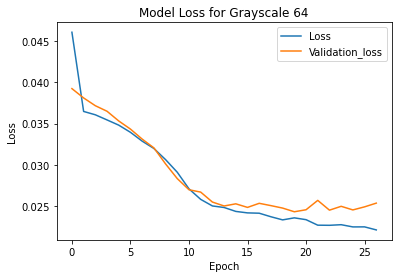

Epoch 1/100
36/36 - 3s - loss: 0.0567 - val_loss: 0.0530
Epoch 2/100
36/36 - 2s - loss: 0.0419 - val_loss: 0.0388
Epoch 3/100
36/36 - 2s - loss: 0.0358 - val_loss: 0.0377
Epoch 4/100
36/36 - 2s - loss: 0.0353 - val_loss: 0.0370
Epoch 5/100
36/36 - 2s - loss: 0.0342 - val_loss: 0.0338
Epoch 6/100
36/36 - 2s - loss: 0.0304 - val_loss: 0.0288
Epoch 7/100
36/36 - 2s - loss: 0.0276 - val_loss: 0.0267
Epoch 8/100
36/36 - 2s - loss: 0.0260 - val_loss: 0.0257
Epoch 9/100
36/36 - 2s - loss: 0.0252 - val_loss: 0.0253
Epoch 10/100
36/36 - 2s - loss: 0.0248 - val_loss: 0.0253
Epoch 11/100
36/36 - 2s - loss: 0.0245 - val_loss: 0.0251
Epoch 12/100
36/36 - 2s - loss: 0.0240 - val_loss: 0.0251
Epoch 13/100
36/36 - 2s - loss: 0.0239 - val_loss: 0.0260
Epoch 14/100
36/36 - 2s - loss: 0.0237 - val_loss: 0.0252
Epoch 15/100
36/36 - 2s - loss: 0.0238 - val_loss: 0.0247
Epoch 16/100
36/36 - 2s - loss: 0.0237 - val_loss: 0.0247
Epoch 17/100
36/36 - 2s - loss: 0.0242 - val_loss: 0.0248
Epoch 18/100
36/36 - 2s

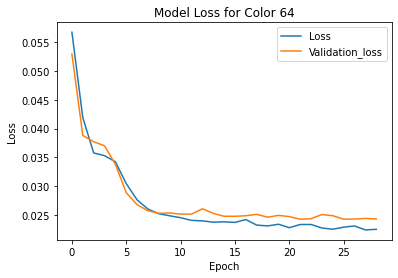

In [71]:
for i in range(2):

  fusion_models[i].compile_model(optimizer='adam')
  fusion_models[i].fit_model(x_train = x[i] , y_train = y_train, x_test =valid[i], y_test = y_test ,epochs = 100,batch_size = 64)
  fusion_models[i].plot()

Not so much difference between models, however last one is the best which is 64 grayscale.


Trying different optimizers

In [72]:
sgd = SGD(lr=.7, momentum=0.9)
adam = Adam(lr=1e-3, decay=1e-3 / 200) #User-defined Adam
all_opts = [sgd,adam,'adam']
opt_names = ['SGD','User-Defined Adam','Default Adam']

Different SGDs are tested and the one with best speed and performance is chosen.

Epoch 1/100
36/36 - 3s - loss: 0.0371 - val_loss: 0.0376
Epoch 2/100
36/36 - 2s - loss: 0.0360 - val_loss: 0.0376
Epoch 3/100
36/36 - 2s - loss: 0.0353 - val_loss: 0.0361
Epoch 4/100
36/36 - 2s - loss: 0.0337 - val_loss: 0.0289
Epoch 5/100
36/36 - 2s - loss: 0.0294 - val_loss: 0.0261
Epoch 6/100
36/36 - 2s - loss: 0.0275 - val_loss: 0.0259
Epoch 7/100
36/36 - 2s - loss: 0.0256 - val_loss: 0.0262
Epoch 8/100
36/36 - 2s - loss: 0.0252 - val_loss: 0.0255
Epoch 9/100
36/36 - 2s - loss: 0.0238 - val_loss: 0.0252
Epoch 10/100
36/36 - 2s - loss: 0.0236 - val_loss: 0.0285
Epoch 11/100
36/36 - 2s - loss: 0.0238 - val_loss: 0.0309
Epoch 12/100
36/36 - 3s - loss: 0.0286 - val_loss: 0.0302
Epoch 13/100
36/36 - 3s - loss: 0.0253 - val_loss: 0.0244
Epoch 14/100
36/36 - 2s - loss: 0.0233 - val_loss: 0.0269
Epoch 15/100
36/36 - 2s - loss: 0.0236 - val_loss: 0.0249
Epoch 16/100
36/36 - 2s - loss: 0.0233 - val_loss: 0.0275
Epoch 17/100
36/36 - 2s - loss: 0.0233 - val_loss: 0.0245
Epoch 18/100
36/36 - 2s

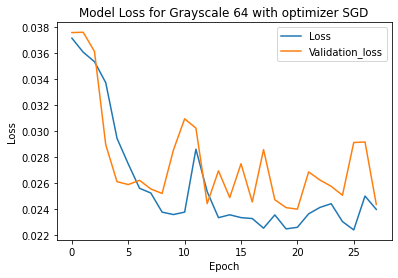

Epoch 1/100
36/36 - 3s - loss: 0.0454 - val_loss: 0.0375
Epoch 2/100
36/36 - 2s - loss: 0.0346 - val_loss: 0.0351
Epoch 3/100
36/36 - 2s - loss: 0.0329 - val_loss: 0.0333
Epoch 4/100
36/36 - 2s - loss: 0.0307 - val_loss: 0.0291
Epoch 5/100
36/36 - 2s - loss: 0.0270 - val_loss: 0.0262
Epoch 6/100
36/36 - 2s - loss: 0.0255 - val_loss: 0.0256
Epoch 7/100
36/36 - 2s - loss: 0.0249 - val_loss: 0.0250
Epoch 8/100
36/36 - 2s - loss: 0.0242 - val_loss: 0.0250
Epoch 9/100
36/36 - 2s - loss: 0.0237 - val_loss: 0.0246
Epoch 10/100
36/36 - 2s - loss: 0.0235 - val_loss: 0.0243
Epoch 11/100
36/36 - 2s - loss: 0.0233 - val_loss: 0.0251
Epoch 12/100
36/36 - 2s - loss: 0.0230 - val_loss: 0.0242
Epoch 13/100
36/36 - 2s - loss: 0.0225 - val_loss: 0.0242
Epoch 14/100
36/36 - 2s - loss: 0.0223 - val_loss: 0.0245
Epoch 15/100
36/36 - 2s - loss: 0.0223 - val_loss: 0.0248
Epoch 16/100
36/36 - 2s - loss: 0.0224 - val_loss: 0.0245
Epoch 17/100
36/36 - 2s - loss: 0.0222 - val_loss: 0.0243
Epoch 18/100
36/36 - 2s

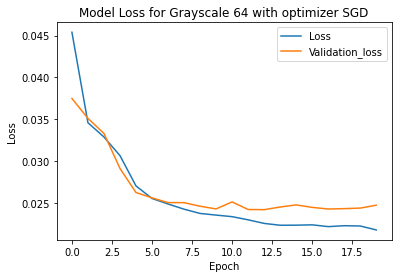

Epoch 1/100
36/36 - 3s - loss: 0.0433 - val_loss: 0.0415
Epoch 2/100
36/36 - 2s - loss: 0.0368 - val_loss: 0.0380
Epoch 3/100
36/36 - 2s - loss: 0.0358 - val_loss: 0.0380
Epoch 4/100
36/36 - 2s - loss: 0.0346 - val_loss: 0.0358
Epoch 5/100
36/36 - 2s - loss: 0.0338 - val_loss: 0.0343
Epoch 6/100
36/36 - 2s - loss: 0.0326 - val_loss: 0.0330
Epoch 7/100
36/36 - 2s - loss: 0.0317 - val_loss: 0.0318
Epoch 8/100
36/36 - 2s - loss: 0.0304 - val_loss: 0.0304
Epoch 9/100
36/36 - 2s - loss: 0.0288 - val_loss: 0.0281
Epoch 10/100
36/36 - 2s - loss: 0.0273 - val_loss: 0.0265
Epoch 11/100
36/36 - 2s - loss: 0.0260 - val_loss: 0.0256
Epoch 12/100
36/36 - 2s - loss: 0.0249 - val_loss: 0.0249
Epoch 13/100
36/36 - 2s - loss: 0.0241 - val_loss: 0.0246
Epoch 14/100
36/36 - 2s - loss: 0.0238 - val_loss: 0.0245
Epoch 15/100
36/36 - 2s - loss: 0.0236 - val_loss: 0.0243
Epoch 16/100
36/36 - 2s - loss: 0.0235 - val_loss: 0.0244
Epoch 17/100
36/36 - 2s - loss: 0.0234 - val_loss: 0.0242
Epoch 18/100
36/36 - 2s

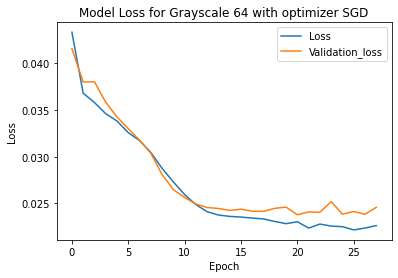

In [73]:
i  = 0 #chosen from last block
opt_models = []

for opt in all_opts :
    
  opt_Network = Network('fusion','Grayscale 64 with optimizer ' + opt_names[i] , dim_img = X_train_gray_64.shape[1:],dim_desc=X_train.shape[1:])
  opt_Network.compile_model(optimizer=opt)
  opt_Network.fit_model(x_train = x[i] , y_train = y_train, x_test =valid[i], y_test = y_test ,epochs = 100,batch_size = 64)
  opt_Network.plot()

  opt_models.append(opt_Network)

<h1>Result:<h1>

The final model result is not so much different with the first mlp model which did not use images and also was so faster.
Maybe having more data images will improve result but we were in lack of time and resource to read 15000 images.

In [74]:
final_model = opt_models[2]

In [75]:
final_model.model.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_7_input (InputLayer)     [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 47, 47, 64)   20800       conv2d_7_input[0][0]             
__________________________________________________________________________________________________
batch_normalization_35 (BatchNo (None, 47, 47, 64)   256         conv2d_7[0][0]                   
__________________________________________________________________________________________________
dropout_55 (Dropout)            (None, 47, 47, 64)   0           batch_normalization_35[0][0]     
______________________________________________________________________________________

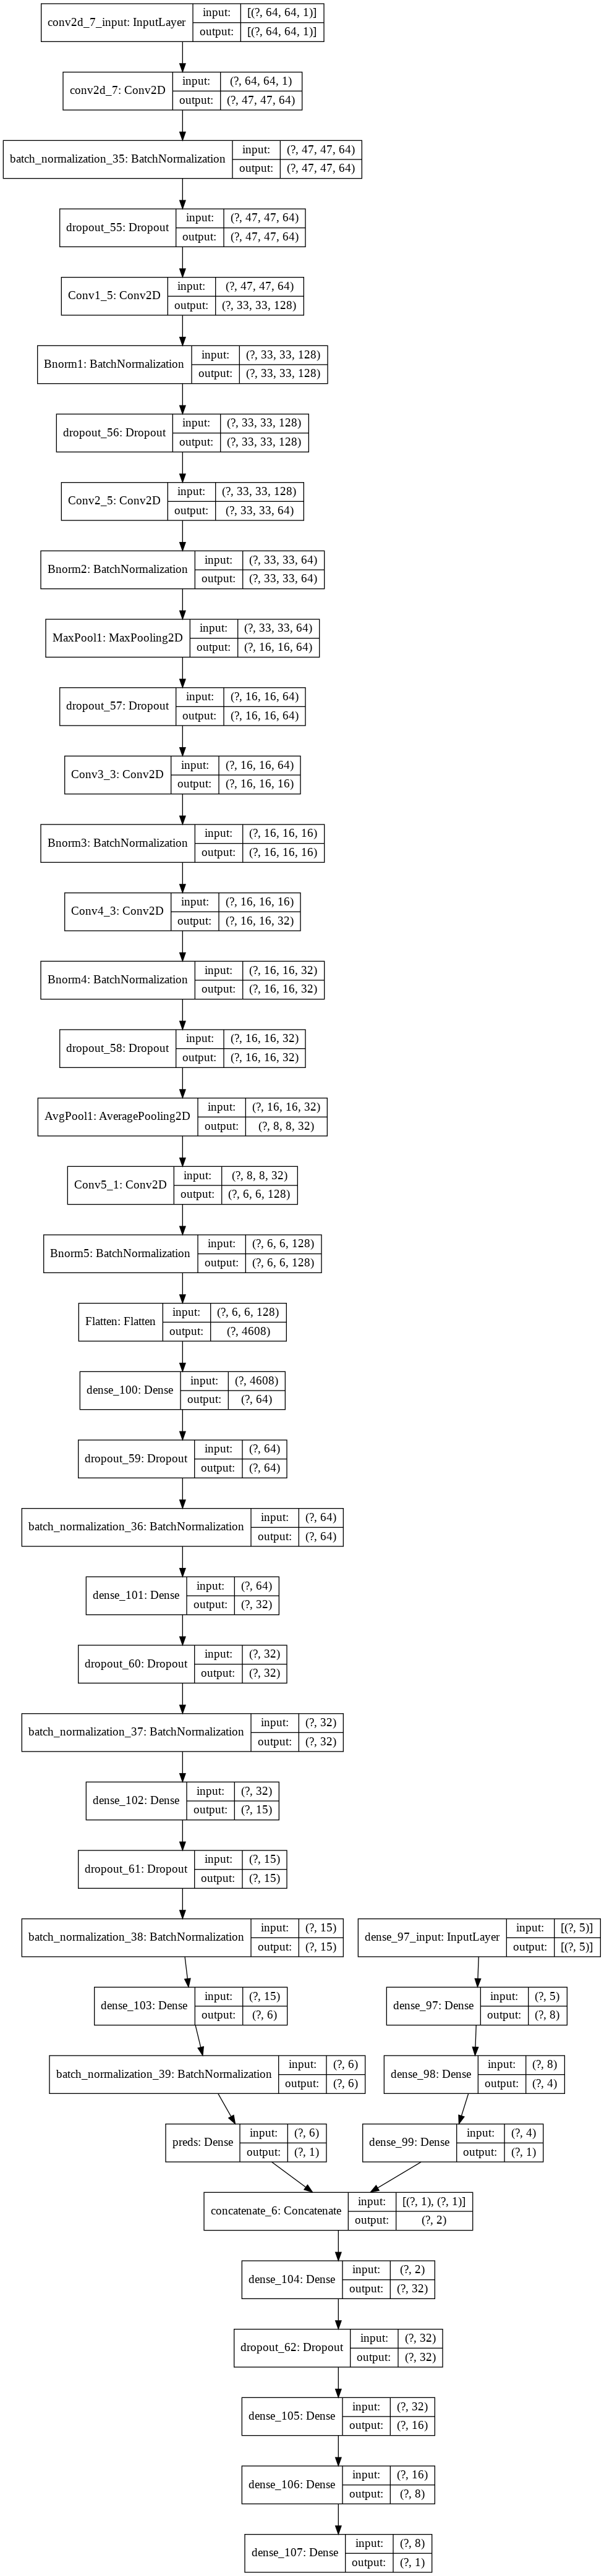

In [76]:
plot_model(final_model.model,show_shapes=True)

###Test Final Network on Validation Set




In [104]:
VALID_SIZE = 100

In [105]:
valid_randoms = random.sample(range(3000), VALID_SIZE)

In [106]:
len(valid_randoms)

100

In [107]:
#Choose new set:

i = 0
valid_images_64 = np.zeros((VALID_SIZE, 64, 64, 3), dtype="uint32")

images_path_ran = [ str(data_dir) + '/' + str(i) + '.jpg' for i in valid_randoms ]
for filename in images_path_ran:

      img = cv2.imread(str(filename))

      if img is not None:

          img_64 = cv2.resize(img, (64, 64))

          valid_images_64[i] = img_64
          i+=1



In [108]:
valid_images_64 = np.array([ cv2.cvtColor(i, cv2.COLOR_RGB2GRAY) for i in valid_images_64.astype('float32')]).reshape(-1,64,64,1)
valid_images_64 = np.array([ cv2.equalizeHist(img.astype(np.uint8)) for img in valid_images_64] ).reshape(-1,64,64,1)

In [109]:
valid_images_64 = valid_images_64.astype('float32') / 255.0

In [110]:
y_valid = ((df['price'] - MIN_PRICE)/ MAX_PRICE)[valid_randoms]
x_valid = X[valid_randoms]

In [111]:
x_valid.shape

(100, 5)

In [112]:
valid_images_64.shape

(100, 64, 64, 1)

In [113]:
preds = final_model.model.predict([x_valid,valid_images_64])

In [114]:
predicts = pd.DataFrame()

predicts['Actual Price']=[round(i*MAX_PRICE + MIN_PRICE) for i in y_valid ]
predicts['Predicted Price']=[round(i[0]*MAX_PRICE + MIN_PRICE) for i in preds ]

predicts['Difference'] = predicts['Actual Price']-predicts['Predicted Price'] 

In [115]:
display(predicts[1:11])

,Actual Price,Predicted Price,Difference
1,1395000,816214.0,578786.0
2,345000,740135.0,-395135.0
3,749000,1261676.0,-512676.0
4,299000,766433.0,-467433.0
5,1888888,739600.0,1149288.0
6,355000,754063.0,-399063.0
7,898000,847020.0,50980.0
8,1049000,919889.0,129111.0
9,360000,867426.0,-507426.0
10,499900,739642.0,-239742.0


In [116]:
import statistics
print(statistics.stdev(predicts['Predicted Price']))
print(statistics.stdev(predicts['Actual Price']))

201759.84054237438
404902.0129142358


In [117]:
from sklearn.metrics import mean_squared_error 

print('Loss on Validation Set is: ',mean_squared_error((predicts['Actual Price']-MIN_PRICE)/MAX_PRICE,(predicts['Predicted Price']-MIN_PRICE)/MAX_PRICE))

Loss on Validation Set is:  0.0657186046935975


In [102]:
import joblib
joblib.dump(value=final_model.model.weights, filename=f"weights_pr2-2.pkl")

['weights_pr2-2.pkl']